In [ ]:
pip install -U pydantic

In [2]:
import pandas as pd
import numpy as np
#Thư viện được sử dụng để tạo báo cáo về dữ liệu:
import ydata_profiling
import os

#Thư viện được sử dụng để tạo đồ thị và biểu đồ trực quan:
import seaborn as sns
import matplotlib.pyplot as plt

#Thư viện được sử dụng để thực hiện các biến đổi cartographic và tính toán địa lý:
from pyproj import Geod

#Thư viện được sử dụng cho các tính toán khoa học:
import scipy

#Thư viện cung cấp các công cụ cho machine learning và data mining:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Phần đường dẫn cố định
relative_path = 'BaoCaoCuoiKy'

# Yêu cầu người dùng nhập ổ đĩa
#(ví dụ: D:/)
drive = input("Nhập ổ đĩa: ")

# Xây dựng đường dẫn tệp đầy đủ
# Ví dụ kết quả đường dẫn là: D:\HOC_KY_2_NAM_3\HocMay + \BaoCaoCuoiKy (tập tin chứa train.csv và test.csv)
# đường dẫn đầy đủ: D:\HOC_KY_2_NAM_3\HocMay\BaoCaoCuoiKy
TRAIN_PATH = os.path.join(drive, relative_path, 'train.csv')
TEST_PATH = os.path.join(drive, relative_path, 'test.csv')


D:\Anacoda\Anacoda setup\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Nhập ổ đĩa: D:\HOC_KY_2_NAM_3\HocMay


In [ ]:
#pip install pydantic==1.8.2

In [ ]:
#pip install --upgrade pandas ydata-profiling

In [ ]:
#pip install lightgbm

# Data Validation and Cleaning (Xác thực và làm sạch dữ liệu)

<strong>Đối với tập dữ liệu test.csv:</strong> </br>
    - Chúng ta sẽ tải test.csv để kiểm tra các giá trị bị thiếu và xem các features (đặc trưng) nằm trong phạm vi giá trị nào. 

In [3]:
test = pd.read_csv(TEST_PATH)
print('Null values:',test.isnull().sum().sum())
test.head()

Null values: 0


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.9733,40.7638,-73.9814,40.7438,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.9869,40.7194,-73.9989,40.7392,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.9825,40.7513,-73.9797,40.7461,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.9812,40.7678,-73.9904,40.7516,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.9660,40.7898,-73.9886,40.7444,1


Tập dữ liệu thử nghiệm (test.csv) đã clean, không có giá trị bị thiếu hoặc bất hợp lý. 


<strong>Đối với tập dữ liệu train.csv:</strong> </br>
    - Tập dữ liệu huấn luyện bao gồm ~ trên 1 triệu hàng. </br>
    - Một tập dữ liệu lớn như vậy sẽ tải và thực hiện các thao tác rất chậm, vì vậy chúng ta sẽ dùng một tập hợp con để kiểm tra nhanh hơn

In [4]:
from ydata_profiling import ProfileReport
import pandas as pd
df_temp = pd.read_csv(TRAIN_PATH, nrows=100000)
profile = ProfileReport(df_temp, title="Profile Report", minimal=True, progress_bar=False)
profile.to_notebook_iframe()

<strong><font color="blue">Dựa vào Profile Report, ta sẽ rút ra được những thông tin sau</font>:</strong></br>

- Cột key được sử dụng làm chỉ mục và có thể bị xóa khi làm việc với dữ liệu. </br>
- Cột fare_amount chứa một số giá trị âm, chúng ta sẽ xóa các hàng này và đặt giới hạn trên hợp lý (plausible upper limit).</br>
- Cột passenger_count chứa một số chuyến đi không có hành khách, chúng ta sẽ xóa các hàng này và đặt giới hạn trên hợp lý.</br>
- Ở các cột như pickup_longitude, pickup_latitude, dropoff_longitude và dropoff_latitude có một số giá trị tọa độ kinh độ (longitude) và vĩ độ (latitude) của các vị trí ở New York City có vẻ không hợp lý. Cụ thể, <strong>vĩ độ của New York City thường nằm trong khoảng 40 và kinh độ thường nằm trong khoảng -73</strong>. Tuy nhiên, trong tập dữ liệu, có một số hàng có giá trị vĩ độ tối thiểu là -74 và kinh độ tối đa là 40, điều này cho thấy có thể các giá trị này đã bị hoán đổi cho nhau trong một số hàng.</br>
<em>- Giải thích điều này:
    - Vĩ độ (latitude) thường là một số dương và nằm trong khoảng từ 40 đến 41 cho khu vực New York City.
    - Kinh độ (longitude) thường là một số âm và nằm trong khoảng từ -74 đến -73 cho khu vực New York City.</em>


In [ ]:
#pip install ydata-profiling

In [ ]:
#from ydata_profiling import ProfileReport


<strong>Chúng ta sẽ thử lấy 5 dòng có pickup_longitude>0 trong tập dữ liệu train.csv để kiểm chứng điều vừa rồi</strong>

In [5]:
df_temp[df_temp['pickup_longitude']>0].head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2147,2013-05-24 14:54:00.00000079,5.0000,2013-05-24 14:54:00 UTC,40.7516,-73.9870,40.7589,-73.9784,2
3827,2013-06-20 04:28:00.0000001,11.0000,2013-06-20 04:28:00 UTC,40.7198,-73.9885,40.7233,-73.9394,1
4783,2013-05-22 06:28:00.0000004,6.5000,2013-05-22 06:28:00 UTC,40.7483,-73.9918,40.7404,-73.9790,1
6705,2013-05-22 15:33:00.000000175,13.0000,2013-05-22 15:33:00 UTC,40.7661,-73.9833,40.7574,-73.9780,2
7525,2013-05-22 10:54:00.000000140,13.0000,2013-05-22 10:54:00 UTC,40.7605,-73.9730,40.7404,-73.9944,1


Dựa vào kết trên, chúng ta đã có thể xác nhận mọi nghi ngờ về việc một số hàng có giá trị kinh độ/vĩ độ đảo ngược là hoàn toàn chính xác. Chúng ta sẽ chuyển các giá trị này về hướng chính xác, sau đó xóa các hàng không chứa giá trị kinh độ/vĩ độ trong NYC.

<strong>Chúng ta sẽ tạo hàm để clean dữ liệu</strong>

In [6]:
def clean_df(df):
    #Chuyển đổi định dạng thời gian
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 15) #Cắt chuỗi pickup_datetime để lấy 15 ký tự đầu tiên
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    #Chuyển đổi chuỗi thời gian thành đối tượng thời gian của Pandas, với múi giờ UTC và định dạng cụ thể.
    
    #Sửa chữa tọa độ bị hoán đổi
    df = df.assign(rev=df.dropoff_latitude<df.dropoff_longitude)
    
    idx = (df['rev'] == 1)# Tạo cột mới rev, đặt giá trị là True nếu dropoff_latitude nhỏ hơn dropoff_longitude, nghĩa là tọa độ có khả năng bị hoán đổi.
    
    df.loc[idx,['dropoff_longitude','dropoff_latitude']] = df.loc[idx,['dropoff_latitude','dropoff_longitude']].values
    df.loc[idx,['pickup_longitude','pickup_latitude']] = df.loc[idx,['pickup_latitude','pickup_longitude']].values
    
    #Loại bỏ các dữ liệu không hợp lệ
    criteria = (
    " 0 < fare_amount <= 500"
    " and 0 < passenger_count <= 6 "
    " and -75 <= pickup_longitude <= -72 "
    " and -75 <= dropoff_longitude <= -72 "
    " and 40 <= pickup_latitude <= 42 "
    " and 40 <= dropoff_latitude <= 42 "
    )
    df = (df
          .dropna()# Loại bỏ các hàng có giá trị null.
          .query(criteria)# Lọc các hàng thỏa mãn điều kiện.
          .reset_index()#Đặt lại chỉ số DataFrame.
          .drop(columns=['rev', 'index'])#Loại bỏ các cột không cần thiết.          
         )
    return df

def load_df(nrows=None, features=None):
    #Định nghĩa các cột cần thiết
    cols = [
        'fare_amount', 'pickup_datetime','pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'
    ]
    #Tải dữ liệu theo từng khối
    df_as_list = []
    for df_chunk in pd.read_csv(TRAIN_PATH, usecols=cols, nrows=nrows, chunksize=5000000):
        df_chunk = clean_df(df_chunk)#Làm sạch dữ liệu cho từng khối bằng hàm clean_df đã định nghĩa ở trên.
        if features == 'explore':
            df_chunk = exploration_features(df_chunk)
        elif features == 'model':
            df_chunk = modelling_features(df_chunk)
        else:
            df_chunk = df_chunk.drop(columns='pickup_datetime')#Nếu không phải để khám phá hoặc mô hình hóa, loại bỏ cột pickup_datetime.
        df_as_list.append(df_chunk)# Thêm khối dữ liệu đã làm sạch vào danh sách.
    df = pd.concat(df_as_list)# Nối tất cả các khối dữ liệu lại với nhau.
    return df

<strong><font color="blue">Tóm lại</font>:</strong></br>
- clean_df: Hàm này làm sạch dữ liệu bằng cách chuyển đổi định dạng thời gian, sửa lỗi hoán đổi tọa độ, và loại bỏ các giá trị không hợp lệ.
- load_df: Hàm này tải dữ liệu từ file CSV theo từng khối, làm sạch dữ liệu từng khối và nối các khối dữ liệu lại với nhau, sau đó trả về DataFrame hoàn chỉnh.

<strong>Mô tả thống kê</strong>

In [7]:
train = load_df(10000000)
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9758850.0000,9758850.0000,9758850.0000,9758850.0000,9758850.0000,9758850.0000
mean,11.3297,-73.9752,40.7510,-73.9743,40.7514,1.6908
std,9.6978,0.0391,0.0300,0.0383,0.0332,1.3066
min,0.0100,-74.9899,40.0000,-74.9983,40.0000,1.0000
25%,6.0000,-73.9923,40.7365,-73.9916,40.7356,1.0000
50%,8.5000,-73.9821,40.7533,-73.9806,40.7539,1.0000
75%,12.5000,-73.9683,40.7675,-73.9654,40.7684,2.0000
max,500.0000,-72.0632,41.9839,-72.0670,41.9981,6.0000


In [8]:
df_temp = pd.read_csv(TRAIN_PATH, nrows=100000)
cleaned_df = clean_df(df_temp)
# print(cleaned_df.head())
print(cleaned_df['fare_amount'].head())

0    4.5000
1   16.9000
2    5.7000
3    7.7000
4    5.3000
Name: fare_amount, dtype: float64


# Data Analysis (Phân tích dữ liệu)

<h2>Phân tích phân phối giá cước</h2>

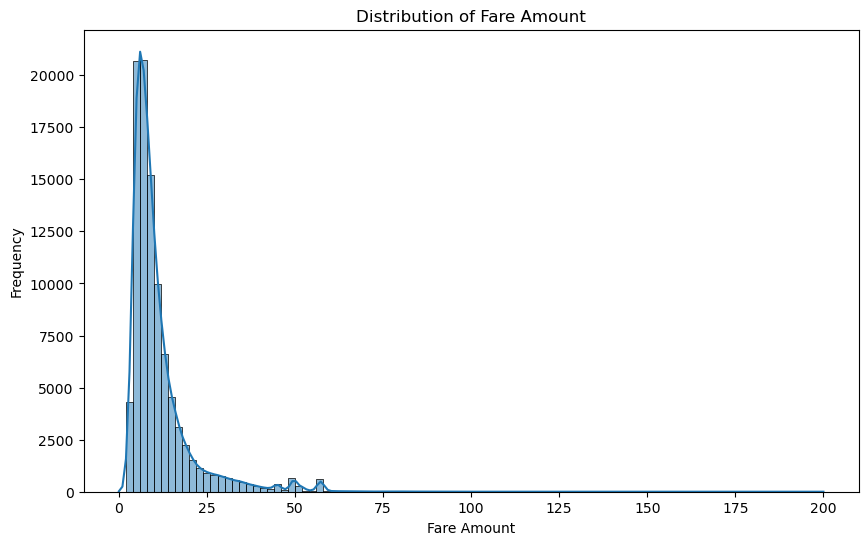

In [9]:
import matplotlib.pyplot as plt
from IPython.display import display;
import seaborn as sns
import pandas as pd
df_temp = pd.read_csv(TRAIN_PATH, nrows=100000)
cleaned_df = clean_df(df_temp)
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['fare_amount'], bins=100, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()
# display(plt.gcf())

In [10]:
# import matplotlib.pyplot as plt

# # Dữ liệu
# x = [1, 2, 3, 4, 5]
# y = [2, 3, 5, 7, 11]

# # Vẽ biểu đồ
# plt.plot(x, y)
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
# plt.title('Đồ thị đơn giản')
# plt.show()

<em>Do giá trị của "fare amount" dao động từ 0 đến 200 đô la với bins=100 thì mỗi ngăn sẽ có độ rộng là 2 dollar </em> </br>
<strong><font color="blue">Dựa vào biểu đồ "Distribution of Fare Amount" ta có thể thấy:</font></strong></br>
- Phần lớn các chuyến đi sẽ có giá cước dưới 50 USD.</br>
- Các chuyến đi với giá cước khoảng 4$-6$ chiếm số lượng nhiều nhất.</br>
- Tuy nhiên, có một số giá trị ngoại lệ rất cao, có thể là do các chuyến đi dài hoặc các lỗi trong dữ liệu.</br>

<h2>Phân tích trung bình giá cước taxi theo ngày trong tuần</h2>

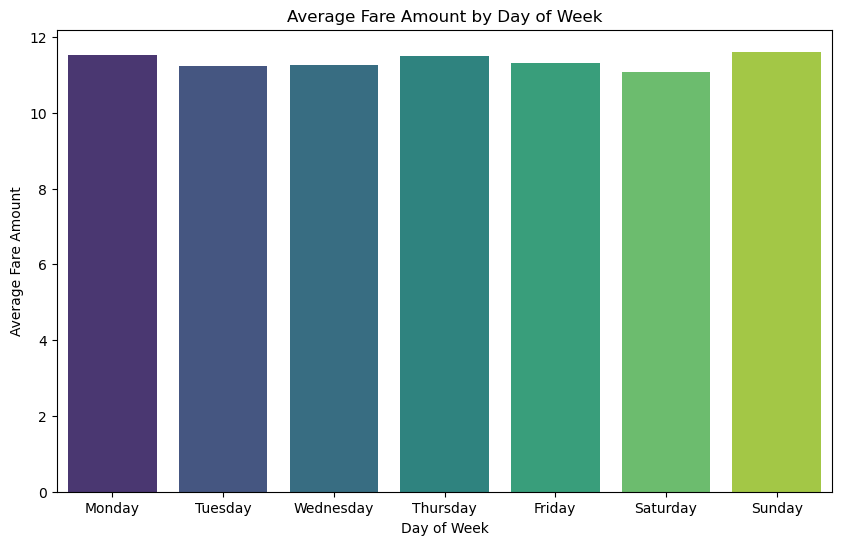

In [11]:
#Thêm cột ngày trong tuần và cột giờ trong ngày
cleaned_df['pickup_datetime'] = pd.to_datetime(cleaned_df['pickup_datetime'])
cleaned_df['day_of_week'] = cleaned_df['pickup_datetime'].dt.dayofweek
cleaned_df['hour_of_day'] = cleaned_df['pickup_datetime'].dt.hour

# Tính giá cước trung bình theo ngày trong tuần
average_fare_by_day = cleaned_df.groupby('day_of_week')['fare_amount'].mean().reset_index()

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='fare_amount', data=average_fare_by_day, palette='viridis')
plt.title('Average Fare Amount by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Fare Amount')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

<strong><font color="blue">Dựa vào biểu đồ "Average Fare Amount by Day of Week" ta có thể thấy:</font></strong></br>
- Trung bình giá cước mỗi ngày trong tuần rơi vào khoảng từ 0 đến gần 12 dollars.</br>
- Ngày chủ nhật có trung bình giá cước cao nhất, điều đó có thể phản ánh sự tăng nhu cầu vào cuối tuần, có thể do các hoạt động giải trí, sự kiện xã hội, hoặc các chuyến đi dài hơn.</br>
- Ngày thứ 7 thì có trung bình giá cước thấp nhất.</br>
- Các ngày còn lại trong tuần có sự phân bố giá cước trung bình khá đều nhau, có thể đây là do nhu cầu di chuyển bằng taxi khi đi làm của người dân của NYC 

<h2>Phân tích trung bình giá cước taxi theo gờ trong ngày</h2>

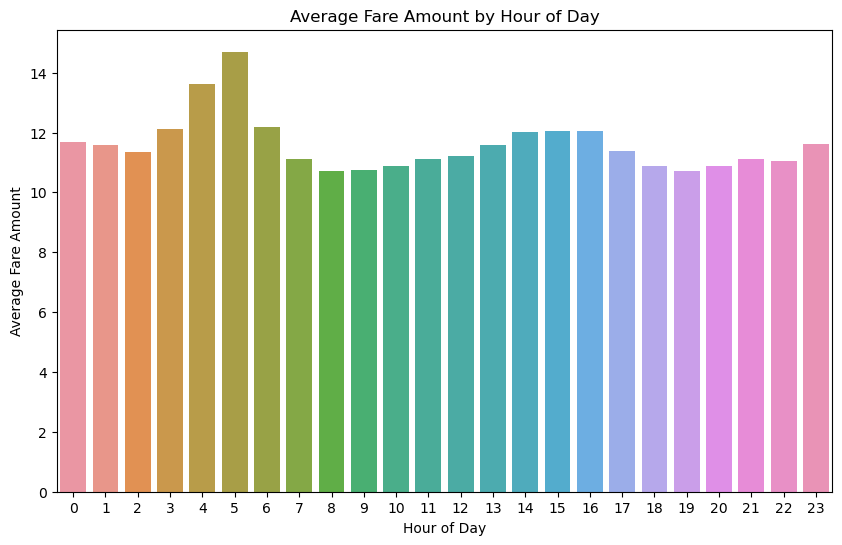

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Giả sử df_train là DataFrame chứa dữ liệu về giá cước taxi và giờ trong ngày
# Đảm bảo rằng df_train có các cột 'hour_of_day' và 'fare_amount'

# Tính trung bình giá cước theo giờ trong ngày
average_fare_by_hour = cleaned_df.groupby('hour_of_day')['fare_amount'].mean().reset_index()

# Tạo biểu đồ cột
# plt.figure(figsize=(12, 6))
# sns.barplot(x='hour_of_day', y='fare_amount', data=average_fare_by_hour, palette='viridis')
# plt.title('Average Fare Amount by Hour of Day')
# plt.xlabel('Hour of Day')
# plt.ylabel('Average Fare Amount')
# plt.show()
plt.figure(figsize=(10, 6))
sns.barplot(x='hour_of_day', y='fare_amount', data=average_fare_by_hour, ci=None)
plt.title('Average Fare Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount')
plt.xticks(range(24))  # Đặt các nhãn x cho từng giờ trong ngày
plt.show()


<strong><font color="blue">Dựa vào biểu đồ "Average Fare Amount by Hour of Day" ta có thể thấy:</font></strong></br>
- Trung bình giá cước mỗi giờ trong ngày rơi vào khoảng từ 0 đến khoảng 16 dollars.</br>
- Giá cước trung bình đạt đỉnh điểm vào khoảng 5h sáng, điều này có thể được giải thích bởi một số người có thể bắt đầu công việc sớm vào buổi sáng, đặc biệt là những người làm việc trong ngành dịch vụ hoặc những người cần phải di chuyển qua khu vực có mật độ giao thông cao như Manhattan, có thể là những chuyến đi dài. Điều này có thể dẫn đến nhu cầu sử dụng dịch vụ đi lại như taxi hoặc ride-hailing tăng lên vào thời điểm này.
- Giá cước trung bình thấp nhất vào khoảng 8h sáng, thì đây là lúc mà tất cả người đi làm đều đang ở cơ quan làm việc, học sinh thì đi học ở trường, nên việc di chuyển bằng taxi có thể ít đi.
- Có thể thấy giá cước taxi trung bình theo giờ trong ngày có sự biến động liên tục.

<h2>Phân tích vị trí đón khách</h2>

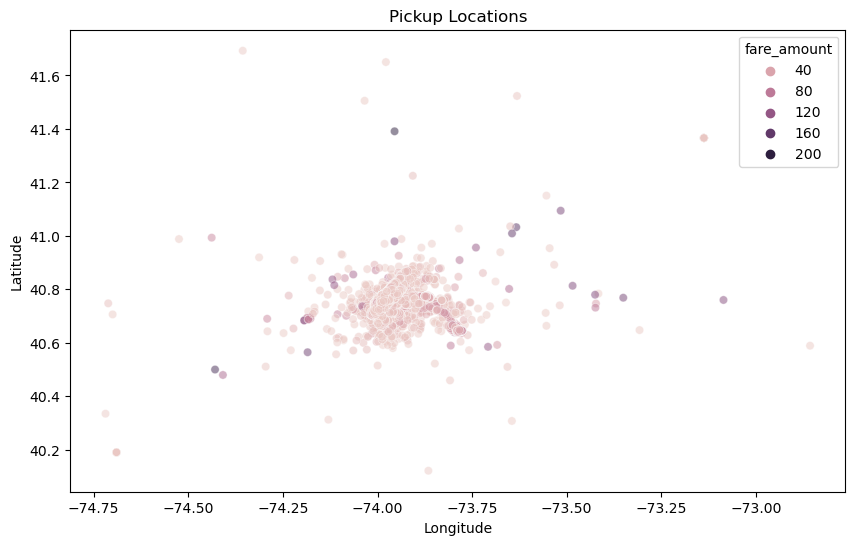

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='fare_amount', data=cleaned_df, alpha=0.5)
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<strong><font color="blue">Dựa vào biểu đồ "Pickup Locations" ta có thể thấy:</font></strong></br>
- Khu vực đón khách chủ yếu ở New York City (NYC) tập trung chủ yếu ở vĩ độ khoảng 40.75 đến 41 và kinh độ từ -74.00 đến -73.75.
- Để biết được đó là những vị trí nào thì ta có thể tra trên google map.
- Trong đó có 1 nơi là tượng nữ thần tự do, có vị trí: 40.7187615,-74.1348721, và khi đối chiếu lên biểu đồ thì ta có thể thấy địa điểm này là nơi đón khách rất đông.
- Đa số các chuyến đi có giá cước dưới 50 USD.

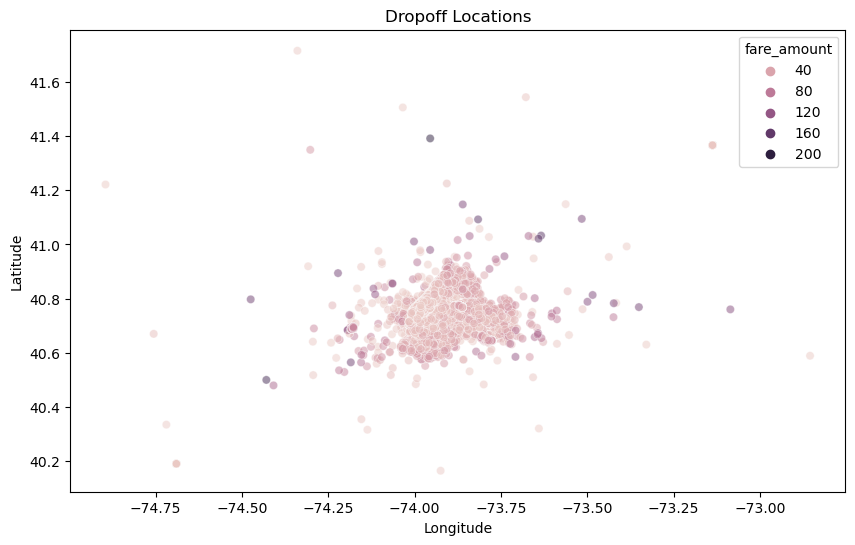

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='fare_amount', data=cleaned_df, alpha=0.5)
plt.title('Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<h2>Phân tích xu hướng giá cước taxi qua từng năm</h2>

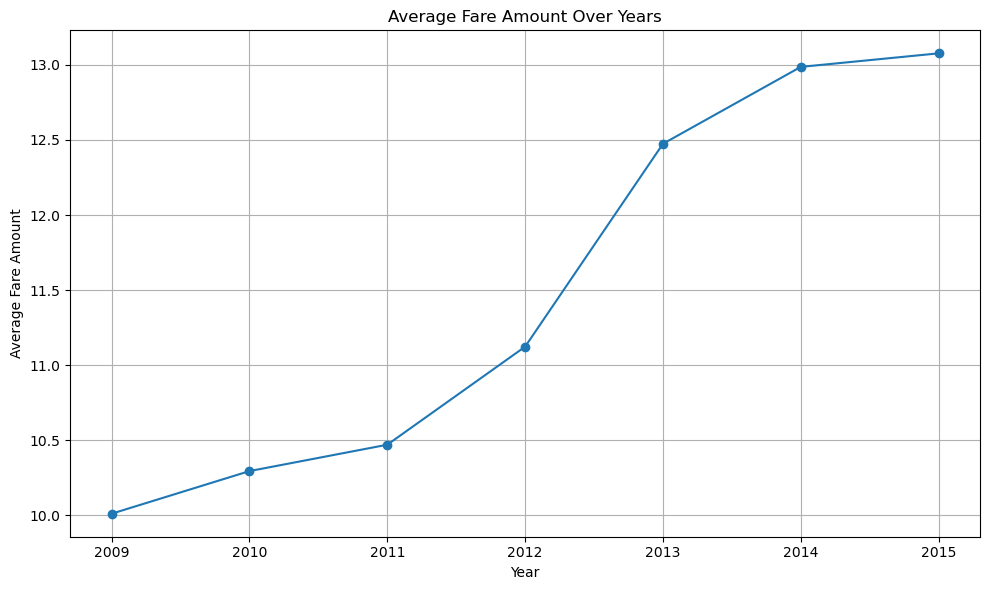

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

cleaned_df['pickup_datetime'] = pd.to_datetime(cleaned_df['pickup_datetime'])
cleaned_df['pickup_year'] = cleaned_df['pickup_datetime'].dt.year
average_fare_per_year = cleaned_df.groupby('pickup_year')['fare_amount'].mean()

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(average_fare_per_year.index, average_fare_per_year.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount Over Years')
plt.grid(True)
plt.xticks(average_fare_per_year.index)
plt.tight_layout()
plt.show()


In [ ]:
train_mini_df = cleaned_df
test_df = test

In [ ]:
import plotly.express as px

col = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

fig = px.scatter_mapbox(pd.concat([train_mini_df[col],test_df[col]]), lat="pickup_latitude", lon="pickup_longitude", hover_name="pickup_datetime", hover_data=[],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=500)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(title="Map of Taxi Pickup Locations")
fig.show()

In [ ]:
col = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

df_train_test = pd.concat([train_mini_df[col],test_df[col]])
df_train_test

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
for i in df_train_test.index:
    if i % 500 == 0:
        fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [df_train_test['pickup_longitude'][i], df_train_test['dropoff_longitude'][i]],
        lat = [df_train_test['pickup_latitude'][i], df_train_test['dropoff_latitude'][i]],
        marker = {'size': 10}))
    else: continue


fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': -73.8443, 'lat': 40.7213},
        'style': "open-street-map",
        'zoom': 6})

fig.show()

# **<span style = 'color:green'>3. Preprocessing Data</span>**<a id ='Preprocessing'></a>


## **<span style = 'color:brown'>3.1 Compute Haversine distance</span>**<a id = 'Haversine'></a>

In [ ]:
# To Compute Haversine distance
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    #Compute haversine distance
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    return 2 * R_earth * np.arcsin(np.sqrt(a))

## **<span style = 'color:brown'>3.2 Compute Radius Distance</span>**<a id = 'Radius'></a>

In [ ]:
def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

## **<span style = 'color:brown'>3.3 Add Airport Locate</span>**<a id = 'Airport'></a>

In [ ]:
def add_airport_dist(dataset):
    """
    Return minumum distance from pickup or dropoff coordinates to each airport.
    JFK: John F. Kennedy International Airport
    EWR: Newark Liberty International Airport
    LGA: LaGuardia Airport
    SOL: Statue of Liberty 
    NYC: Newyork Central
    """
    jfk_coord = (40.639722, -73.778889)
    ewr_coord = (40.6925, -74.168611)
    lga_coord = (40.77725, -73.872611)
    sol_coord = (40.6892,-74.0445) # Statue of Liberty
    nyc_coord = (40.7141667,-74.0063889) 
    
    
    pickup_lat = dataset['pickup_latitude']
    dropoff_lat = dataset['dropoff_latitude']
    pickup_lon = dataset['pickup_longitude']
    dropoff_lon = dataset['dropoff_longitude']
    
    pickup_jfk = sphere_dist(pickup_lat, pickup_lon, jfk_coord[0], jfk_coord[1]) 
    dropoff_jfk = sphere_dist(jfk_coord[0], jfk_coord[1], dropoff_lat, dropoff_lon) 
    pickup_ewr = sphere_dist(pickup_lat, pickup_lon, ewr_coord[0], ewr_coord[1])
    dropoff_ewr = sphere_dist(ewr_coord[0], ewr_coord[1], dropoff_lat, dropoff_lon) 
    pickup_lga = sphere_dist(pickup_lat, pickup_lon, lga_coord[0], lga_coord[1]) 
    dropoff_lga = sphere_dist(lga_coord[0], lga_coord[1], dropoff_lat, dropoff_lon)
    pickup_sol = sphere_dist(pickup_lat, pickup_lon, sol_coord[0], sol_coord[1]) 
    dropoff_sol = sphere_dist(sol_coord[0], sol_coord[1], dropoff_lat, dropoff_lon)
    pickup_nyc = sphere_dist(pickup_lat, pickup_lon, nyc_coord[0], nyc_coord[1]) 
    dropoff_nyc = sphere_dist(nyc_coord[0], nyc_coord[1], dropoff_lat, dropoff_lon)
    
    
    
    dataset['jfk_dist'] = pickup_jfk + dropoff_jfk
    dataset['ewr_dist'] = pickup_ewr + dropoff_ewr
    dataset['lga_dist'] = pickup_lga + dropoff_lga
    dataset['sol_dist'] = pickup_sol + dropoff_sol
    dataset['nyc_dist'] = pickup_nyc + dropoff_nyc
    
    return dataset

## **<span style = 'color:brown'>3.4 Preprocess </span>**<a id = 'Preprocess'></a>

In [ ]:
def radian_conv(degree):
    return  np.radians(degree)    

In [ ]:
def datetime_parse(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset


In [ ]:
def clean_df(df):
    return df[(df.fare_amount > 0)  & (df.fare_amount <= 500) &
           (df.pickup_longitude >= -75) & (df.pickup_latitude >= 40) & (df.dropoff_longitude <= -72) & (df.dropoff_latitude >= 42) &
           ((df.pickup_longitude != 0) & (df.pickup_latitude != 0) & (df.dropoff_longitude != 0) & (df.dropoff_latitude != 0) )]

# **<span style = 'color:green'>4. Feature Analytic</span>**<a id ='Analytic'></a>

- Read sample data for train

In [ ]:
df_train =  pd.read_csv(TRAIN_PATH, nrows = 900000)

- drop miss value

In [ ]:
df_train = df_train.dropna(how = 'any', axis = 'rows')

- clear data outline

In [ ]:
df_train = clean_df(df_train)

- Date process

In [ ]:
df_train = datetime_parse(df_train)

- Feature process

In [ ]:
df_train = add_airport_dist(df_train)
df_train['distance'] = sphere_dist(df_train['pickup_latitude'], df_train['pickup_longitude'], 
                                   df_train['dropoff_latitude'] , df_train['dropoff_longitude']) 

df_train['bearing'] = sphere_dist_bear(df_train['pickup_latitude'], df_train['pickup_longitude'], 
                                   df_train['dropoff_latitude'] , df_train['dropoff_longitude'])                                    
df_train['pickup_latitude'] = radian_conv(df_train['pickup_latitude'])
df_train['pickup_longitude'] = radian_conv(df_train['pickup_longitude'])
df_train['dropoff_latitude'] = radian_conv(df_train['dropoff_latitude'])
df_train['dropoff_longitude'] = radian_conv(df_train['dropoff_longitude'])

# **<span style = 'color:green'>5. Build Model</span>**<a id ='Build'></a>


## **<span style = 'color:brown'>5.1 Train-Val split </span>**<a id = 'split'></a>

In [ ]:
df_train.drop(columns=['key', 'pickup_datetime'], inplace=True)

y = df_train['fare_amount']
df_train = df_train.drop(columns=['fare_amount'])


df_train.head()

In [ ]:
x_train,x_val,y_train,y_val = train_test_split(df_train,y,random_state=123,test_size=0.10)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(6, 3, figsize=(20,22))
sns.distplot(x_train['hour'], ax=ax[0, 0])
sns.distplot(x_train['pickup_longitude'], ax=ax[0, 1])
sns.distplot(x_train['pickup_latitude'], ax=ax[0, 2])
sns.distplot(x_train['dropoff_longitude'], ax=ax[1, 0])

sns.distplot(x_train['dropoff_latitude'], ax=ax[1, 1])
sns.distplot(x_train['passenger_count'], ax=ax[1, 2])
sns.distplot(x_train['hour'], ax=ax[2, 0])
sns.distplot(x_train['day'], ax=ax[2, 1])
sns.distplot(x_train['month'], ax=ax[2, 2])
sns.distplot(x_train['weekday'], ax=ax[3, 0])
sns.distplot(x_train['year'], ax=ax[3, 1])
sns.distplot(x_train['jfk_dist'], ax=ax[3, 2])
sns.distplot(x_train['ewr_dist'], ax=ax[4, 0])
sns.distplot(x_train['lga_dist'], ax=ax[4, 1])
sns.distplot(x_train['sol_dist'], ax=ax[4, 2])
sns.distplot(x_train['nyc_dist'], ax=ax[5, 0])
sns.distplot(x_train['distance'], ax=ax[5, 1])
sns.distplot(x_train['bearing'], ax=ax[5, 2])

plt.show()

In [ ]:
x_train.info()
